# BFCL Error Analysis

This notebook loads outputs from `analyze_errors.py` and generates summary tables and plots for RQ2.

In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

outdir = Path('analysis_out')
master_path = outdir / 'master_rows.parquet'
paired_path = outdir / 'paired_outcomes.parquet'
run_summary_path = outdir / 'run_summaries.parquet'

if master_path.exists():
    master_rows = pd.read_parquet(master_path)
else:
    master_rows = pd.read_csv(outdir / 'master_rows.csv')

if paired_path.exists():
    paired = pd.read_parquet(paired_path)
else:
    paired = pd.read_csv(outdir / 'paired_outcomes.csv')

if run_summary_path.exists():
    run_summaries = pd.read_parquet(run_summary_path)
else:
    run_summaries = pd.read_csv(outdir / 'run_summaries.csv')

master_rows.head(-1)

,condition,model_name,category,run_name,id,is_error,is_correct,error_type,error_text,sub_error_type,model_output_item,possible_answer_item,raw_error,prompt,macro_bucket,score_file,result_file
0,OO,azure-gpt-4o-FC,agentic,BFCL_v4_web_search_base,web_search_base_0,False,True,None,None,None,None,None,None,None,other,score_desc_original_name_original\azure-gpt-4o...,result_desc_original_name_original\azure-gpt-4...
1,OO,azure-gpt-4o-FC,agentic,BFCL_v4_web_search_base,web_search_base_1,False,True,None,None,None,None,None,None,None,other,score_desc_original_name_original\azure-gpt-4o...,result_desc_original_name_original\azure-gpt-4...
2,OO,azure-gpt-4o-FC,agentic,BFCL_v4_web_search_base,web_search_base_2,True,False,agentic:answer_not_found,None of the expected answers were found in the...,None,None,None,"{""error_message"": ""None of the expected answer...","[[{""role"": ""system"", ""content"": ""For your fina...",other,score_desc_original_name_original\azure-gpt-4o...,result_desc_original_name_original\azure-gpt-4...
3,OO,azure-gpt-4o-FC,agentic,BFCL_v4_web_search_base,web_search_base_3,True,False,agentic:inference_error,Error during inference phase. Model did not ou...,None,None,None,"{""error_message"": [""Error during inference pha...","{""id"": ""web_search_base_3"", ""question"": [[{""ro...",execution_runtime,score_desc_original_name_original\azure-gpt-4o...,result_desc_original_name_original\azure-gpt-4...
4,OO,azure-gpt-4o-FC,agentic,BFCL_v4_web_search_base,web_search_base_4,False,True,None,None,None,None,None,None,None,other,score_desc_original_name_original\azure-gpt-4o...,result_desc_original_name_original\azure-gpt-4...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,AA,azure-gpt-4o-FC,agentic,BFCL_v4_web_search_base,web_search_base_94,True,False,agentic:answer_not_found,None of the expected answers were found in the...,None,None,None,"{""error_message"": ""None of the expected answer...","[[{""role"": ""system"", ""content"": ""For your fina...",other,score_desc_augmented_name_augmented\azure-gpt-...,result_desc_augmented_name_augmented\azure-gpt...
395,AA,azure-gpt-4o-FC,agentic,BFCL_v4_web_search_base,web_search_base_95,False,True,None,None,None,None,None,None,None,other,score_desc_augmented_name_augmented\azure-gpt-...,result_desc_augmented_name_augmented\azure-gpt...
396,AA,azure-gpt-4o-FC,agentic,BFCL_v4_web_search_base,web_search_base_96,False,True,None,None,None,None,None,None,None,other,score_desc_augmented_name_augmented\azure-gpt-...,result_desc_augmented_name_augmented\azure-gpt...
397,AA,azure-gpt-4o-FC,agentic,BFCL_v4_web_search_base,web_search_base_97,True,False,agentic:answer_not_found,None of the expected answers were found in the...,None,None,None,"{""error_message"": ""None of the expected answer...","[[{""role"": ""system"", ""content"": ""For your fina...",other,score_desc_augmented_name_augmented\azure-gpt-...,result_desc_augmented_name_augmented\azure-gpt...


In [5]:
# Filter to models of interest (edit as needed)
models_of_interest = ['gpt-4o', 'gpt-5.1']
mask = master_rows['model_name'].str.contains('|'.join(models_of_interest), case=False, na=False)
master_rows_focus = master_rows[mask].copy()

master_rows_focus['condition'].value_counts()

condition
OO    100
OA    100
AO    100
AA    100
Name: count, dtype: int64

## Macro bucket shares by condition

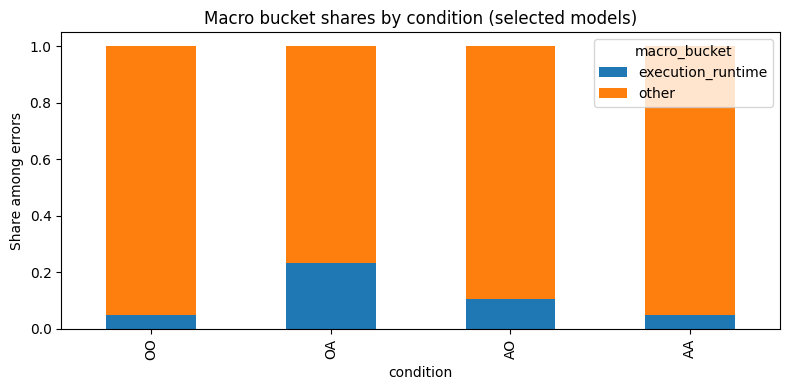

In [6]:
def plot_macro_bucket_shares(df, title):
    if df.empty:
        print('No data to plot')
        return
    counts = df.groupby(['condition', 'macro_bucket']).size().reset_index(name='count')
    total = counts.groupby('condition')['count'].transform('sum')
    counts['share'] = counts['count'] / total
    pivot = counts.pivot(index='condition', columns='macro_bucket', values='share').fillna(0)
    pivot = pivot.reindex(['OO','OA','AO','AA']).dropna(how='all')
    pivot.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.title(title)
    plt.ylabel('Share among errors')
    plt.tight_layout()

plot_macro_bucket_shares(master_rows_focus[master_rows_focus['is_error']], 'Macro bucket shares by condition (selected models)')

## Top error_type delta (OO to AA)

,OO,AA,delta
error_type,,,
agentic:answer_not_found,58,58,0
agentic:inference_error,3,3,0


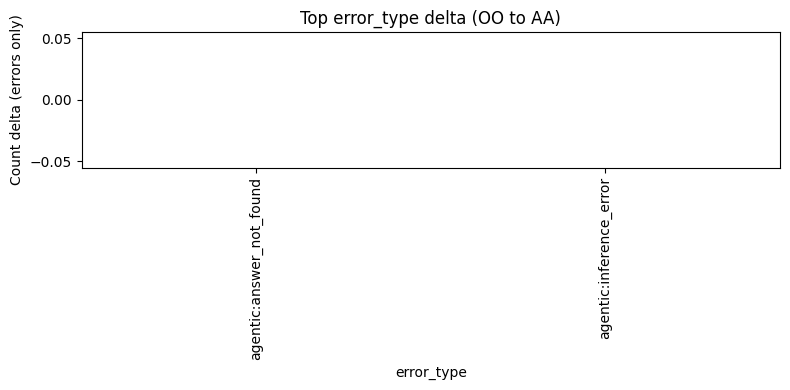

In [7]:
def top_error_type_delta(df, top_n=10):
    oo = df[df['condition'] == 'OO']['error_type'].value_counts()
    aa = df[df['condition'] == 'AA']['error_type'].value_counts()
    delta = pd.concat([oo, aa], axis=1).fillna(0)
    delta.columns = ['OO', 'AA']
    delta['delta'] = delta['AA'] - delta['OO']
    return delta.sort_values('delta', ascending=False).head(top_n)

err_df = master_rows_focus[master_rows_focus['is_error']]
if not err_df.empty:
    delta = top_error_type_delta(err_df)
    display(delta)
    delta['delta'].plot(kind='bar', figsize=(8,4))
    plt.title('Top error_type delta (OO to AA)')
    plt.ylabel('Count delta (errors only)')
    plt.tight_layout()

## 16-way pattern distribution by category

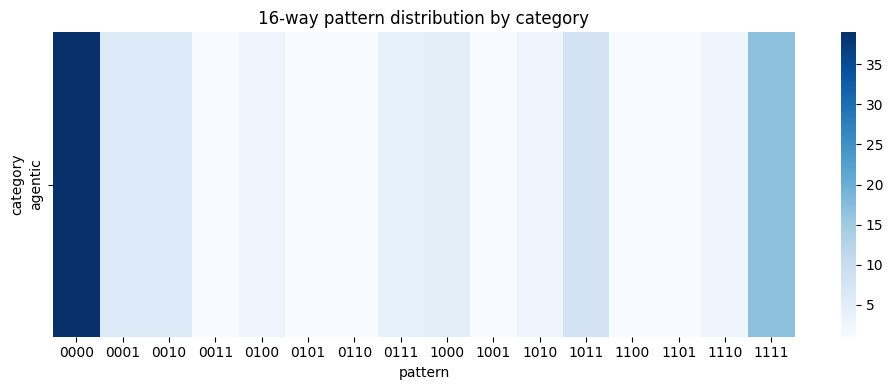

In [8]:
def pattern_heatmap(paired_df, title):
    if paired_df.empty or 'pattern' not in paired_df.columns:
        print('No pattern data')
        return
    table = paired_df.groupby(['category', 'pattern']).size().reset_index(name='count')
    pivot = table.pivot(index='category', columns='pattern', values='count').fillna(0)
    plt.figure(figsize=(10, max(4, len(pivot) * 0.3)))
    sns.heatmap(pivot, cmap='Blues', cbar=True)
    plt.title(title)
    plt.tight_layout()

pattern_heatmap(paired, '16-way pattern distribution by category')

## Transition counts by category

In [9]:
def transition_counts(paired_df):
    cols = [c for c in paired_df.columns if c.startswith('fixed_by_') or c.startswith('broken_by_')]
    if not cols:
        print('No transition columns')
        return
    table = paired_df.groupby('category')[cols].sum().reset_index()
    display(table.head(100))

transition_counts(paired)

,category,fixed_by_OA,broken_by_OA,fixed_by_AO,broken_by_AO,fixed_by_AA,broken_by_AA
0,agentic,9,17,12,8,12,12


## Example gallery: fixed and broken by AA

In [10]:
def example_gallery(master_rows_df, paired_df, n=5):
    if 'fixed_by_AA' not in paired_df.columns or 'broken_by_AA' not in paired_df.columns:
        print('AA transitions not available')
        return
    fixed_ids = paired_df[paired_df['fixed_by_AA']].head(n)[['model_name','category','id']]
    broken_ids = paired_df[paired_df['broken_by_AA']].head(n)[['model_name','category','id']]

    def extract_examples(subset, label, condition):
        examples = master_rows_df.merge(subset, on=['model_name','category','id'], how='inner')
        examples = examples[examples['condition'] == condition]
        cols = ['id','category','error_type','error_text','prompt']
        for col in cols:
            if col not in examples.columns:
                examples[col] = None
        examples = examples[cols].head(n).copy()
        if examples.empty:
            print(f"{label}: no matching rows")
            return
        examples['error_text'] = examples['error_text'].astype(str).str.slice(0, 160)
        examples['prompt'] = examples['prompt'].astype(str).str.slice(0, 200)
        print(f"{label}")
        display(examples)

    extract_examples(fixed_ids, 'Fixed by AA (OO errors)', 'OO')
    extract_examples(broken_ids, 'Broken by AA (AA errors)', 'AA')

example_gallery(master_rows_focus, paired, n=5)

Fixed by AA (OO errors)


,id,category,error_type,error_text,prompt
0,web_search_base_2,agentic,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
1,web_search_base_5,agentic,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
2,web_search_base_22,agentic,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
3,web_search_base_36,agentic,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
4,web_search_base_96,agentic,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."


Broken by AA (AA errors)


,id,category,error_type,error_text,prompt
15,web_search_base_38,agentic,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
16,web_search_base_45,agentic,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
17,web_search_base_76,agentic,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
18,web_search_base_80,agentic,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
19,web_search_base_89,agentic,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."


## Optional: export HTML report

In [9]:
# Uncomment to export if nbconvert is available
import subprocess
subprocess.run(['jupyter', 'nbconvert', '--to', 'html', 'error_analysis.ipynb', '--output', 'error_report.html'])

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'html', 'error_analysis.ipynb', '--output', 'error_report.html'], returncode=0)

## Category summary (aligned universe)

,model_name,category,total_tasks,error_rate_OO,error_rate_OA,error_rate_AO,error_rate_AA,always_correct_rate,fixed_by_AA_rate,broken_by_AA_rate
0,azure-gpt-4o-FC,agentic,100,0.61,0.69,0.57,0.61,0.17,0.12,0.12


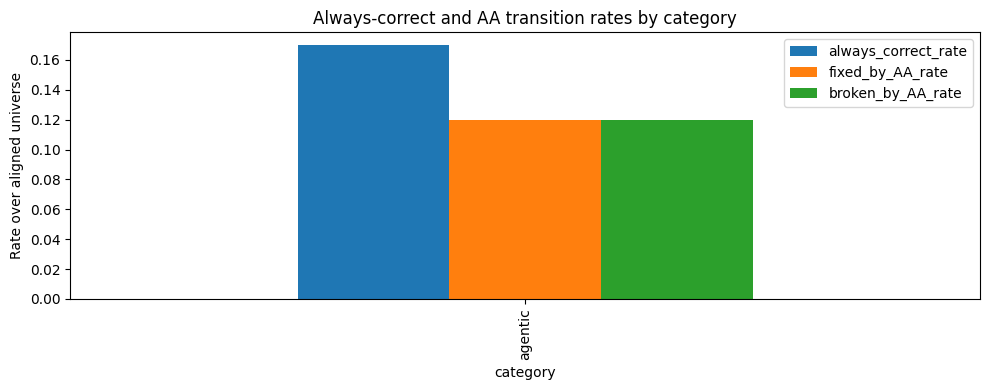

In [11]:
from pathlib import Path
summary_path = Path('analysis_out/summary_tables/category_summary.csv')
if summary_path.exists():
    category_summary = pd.read_csv(summary_path)
    display(category_summary.head(10))

    # Plot always-correct, fixed_by_AA, broken_by_AA rates by category
    plot_cols = ['always_correct_rate', 'fixed_by_AA_rate', 'broken_by_AA_rate']
    available = [c for c in plot_cols if c in category_summary.columns]
    if available:
        pivot = category_summary.set_index('category')[available]
        pivot.plot(kind='bar', figsize=(10,4))
        plt.title('Always-correct and AA transition rates by category')
        plt.ylabel('Rate over aligned universe')
        plt.tight_layout()